In [122]:
import nilearn
import nibabel as nib

import os
import pandas as pd
import numpy as np
import nibabel as nib
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
#from jupyterthemes import jtplot
#jtplot.style('onedork')

from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiMapsMasker
from nilearn.image import concat_imgs, index_img, mean_img, math_img
from nilearn._utils import check_niimg
%matplotlib inline

In [123]:
def get_fn(sub, ses, run=1, echo_n=None, combmode=None, denoised=False,
           root_dir='/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep'):
    if not isinstance(sub, str):
        sub = str(sub).zfill(2)

    if ses == 'se':
        hdr = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'.format(sub, sub, run))
        mask = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(sub, sub, run))
    elif ses == 'me':
        mask = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'.format(sub, sub, run))
        if echo_n is None and combmode is not None:
            if denoised:
                hdr = './lcat_denoising/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_bold_lcat-den.nii.gz'.format(sub, run)
            else:
                hdr = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp-{}_bold.nii.gz'.format(sub, sub, run, combmode))
        elif echo_n is not None and combmode is None:
            if denoised:
                hdr = './lcat_denoising/sub-{}_ses-me_task-stop_run-{}_echo-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-den.nii.gz'.format(sub, echo_n, run)
            else:
                hdr = os.path.join(root_dir, 'sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-{}_echo-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'.format(sub, sub, run, echo_n))

        else:
            raise(IOError('Requires either combmode or echo_n'))
    
    return hdr, mask

def make_tSNR_map(sub, ses, run=1, echo_n=None, combmode=None, denoised=False, save=True, overwrite=False):
    for run in [1,2,3]:
        hdr_fn, mask_fn = get_fn(sub, ses, run, echo_n, combmode, denoised=denoised)
        output_fn = hdr_fn.replace("_bold", "_tsnr")
        if os.path.exists(output_fn) and not overwrite:
            continue
        
        hdr = nib.load(hdr_fn)
        data = hdr.get_data()
        sig = np.mean(data, axis=3)
        noise = np.std(data, axis=3)
        tsnr = sig/noise
        
        tsnr = np.clip(tsnr, a_min=0, a_max=250)
        
        mask = nib.load(mask_fn).get_data()
        sig[mask==0] = 0
        noise[mask==0] = 0
        tsnr[mask==0] = 0
        
        sig = nib.Nifti1Image(sig, affine=hdr.affine)
        noise = nib.Nifti1Image(noise, affine=hdr.affine)
        tsnr = nib.Nifti1Image(tsnr, affine=hdr.affine)
        
        output = concat_imgs([tsnr, sig, noise])
        nib.save(output, output_fn)
        print(output_fn)
    return 0

# Calculate voxel-wise tSNR

In [124]:
import multiprocessing as mp
from functools import partial
import itertools
subs = [x for x in np.arange(1, 19) if not x == 12]
ses = ['se', 'optcomb', 1, 2, 3]
to_run = list(itertools.product(subs, ses))

def mp_helper(to_run, overwrite=False):
    sub, ses = to_run
    
    if ses == 'se':
        make_tSNR_map(sub, ses, overwrite=overwrite)
    elif ses == 'optcomb':
        make_tSNR_map(sub, ses='me', combmode='optcomb', overwrite=overwrite)
    else:
        make_tSNR_map(sub, ses='me', echo_n=ses, overwrite=overwrite)

In [95]:
with mp.Pool(15) as p:
    p.map(partial(mp_helper, overwrite=False), to_run)

## Extract ROI-wise tSNRs
Weighted average of all voxels in mask

In [170]:
get_fn(1, ses='me', combmode='optcomb', run=1)[0].replace('_bold', '_cnr')

'/home/stevenm/MultiEchoEPISeq/data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_cnr.nii.gz'

In [259]:
from utils import *
atlas = load_atlas()

def get_fn_short(sub, ses=None, run=1, output_type='tsnr'):
    if ses == 'se':
        bold = get_fn(sub, 'se', run=run)[0]
    elif ses == 'optcomb':
        bold = get_fn(sub, ses='me', combmode=ses, run=run)[0]
    else:
        bold = get_fn(sub, ses='me', echo_n=ses[-1], run=run)[0]
    
    if output_type == 'tsnr':
        return bold.replace('_bold', '_tsnr')
    elif output_type == 'cnr':
        return bold.replace('_bold', '_cnr')

def get_roi_values(nii, atlas):
    data = nii.get_data()
    
    # identify voxels that shouldn't be weighted: cnr/tsnr can't be <0, >1000, or nan.
    # these can arise, mostly at the edges of the brain, due to numerical issues (T2* estimation, division by small noise, etc)
    bad_voxel_idx = (data < 0) | (data > 1000) | np.isnan(data)
    # set to 0 in data
    data[bad_voxel_idx] = 0
    
    out = pd.Series(index=pd.Index(atlas.labels))
    for mask_id in np.arange(atlas.maps.shape[-1]):
        # get in mask
        mask_label = [x for x in atlas.labels][mask_id]
        this_mask = index_img(atlas.maps, mask_id).get_data()
        this_mask[bad_voxel_idx] = 0  # bad values, don't weigh these
        
        val_weighted = np.average(data, weights=this_mask)  # inf * 0 = np.nan -> manually set np.nans to 0
        out[mask_label] = val_weighted
    return out

def _make_fn_df(output_type='tsnr'):
    subs = [str(x).zfill(2) for x in np.arange(1, 19) if not x == 12]
    runs = [1,2,3]
    data_types = ['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']
    index = pd.MultiIndex.from_product([subs, data_types, runs], names=['subject', 'data_type', 'run'])
    fn_df = pd.DataFrame(index=index, columns=['fn'])
    fn_df['fn'] = fn_df.reset_index().apply(lambda x: get_fn_short(x['subject'], x['data_type'], x['run'], output_type=output_type), axis=1).values
    
    # check if all niis exist, load only those that exist
    fn_df['exists'] = fn_df['fn'].apply(os.path.exists)
    fn_df = fn_df[fn_df['exists']]
    if output_type == 'tsnr':
        fn_df['nii'] = fn_df['fn'].apply(lambda x: index_img(x, 0)) # don't forget to index: first is the tSNR
    else:
        fn_df['nii'] = fn_df['fn'].apply(nib.load)
    return fn_df

def get_subjectwise_rois(output_type='tsnr', atlas=atlas):
    fn_df = _make_fn_df(output_type=output_type)
    # get mean across runs
    means_across_runs = fn_df.groupby(['data_type', 'subject']).apply(lambda x: mean_img(x['nii']))
    roiwise_df = means_across_runs.apply(get_roi_values, atlas=atlas)
    return roiwise_df

def get_wholebrain_niis(output_type='tsnr'):
    fn_df = _make_fn_df(output_type=output_type)
    
    # get mean across runs
    means_across_runs = fn_df.groupby(['data_type', 'subject']).apply(lambda x: mean_img(x['nii']))
    
    # and across subs
    means_across_subs = means_across_runs.reset_index().groupby('data_type').apply(lambda x: mean_img(x[0]))    
    
    return means_across_subs

### tSNR analysis

In [151]:
subjectwise_tsnrs = get_subjectwise_rois('tsnr')

In [152]:
index_order = ['Single echo', 'Multi echo combined', 'Echo 1', 'Echo 2', 'Echo 3']
column_order = ['rM1', 'rPreSMA', 'rIFG', 'rSTR', 'rGPe', 'rGPi', 'rSTN', 'lSTN']

In [153]:
roiwise_tsnr = subjectwise_tsnrs.groupby(level=[0]).mean()[column_order]
roiwise_tsnr = roiwise_tsnr.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_tsnr.index.name = 'Data type'
roiwise_tsnr = roiwise_tsnr.reindex(index = index_order)
roiwise_tsnr.round(2)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN,lSTN
Data type,,,,,,,,
Single echo,93.25,87.16,82.67,73.67,55.67,58.50,59.70,59.01
Multi echo combined,62.00,60.52,58.73,43.38,31.63,32.54,34.58,34.85
Echo 1,73.65,67.00,66.66,44.93,32.11,32.37,34.55,34.81
Echo 2,41.71,42.22,40.11,23.76,10.97,12.48,14.30,14.58
Echo 3,25.66,27.65,24.54,13.25,5.60,6.48,6.16,6.20


In [154]:
roiwise_tsnr_std = subjectwise_tsnrs.groupby(level=[0]).std()[column_order]
roiwise_tsnr_std = roiwise_tsnr_std.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_tsnr_std.index.name = 'Data type'
roiwise_tsnr_std = roiwise_tsnr_std.reindex(index = index_order)
roiwise_tsnr_std.round(2)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN,lSTN
Data type,,,,,,,,
Single echo,15.97,13.39,15.70,10.91,9.69,8.92,8.22,8.23
Multi echo combined,8.92,7.54,9.25,4.34,3.68,4.20,3.47,3.35
Echo 1,7.42,6.39,7.92,4.10,3.84,4.34,4.12,3.88
Echo 2,4.37,4.37,5.70,2.93,1.57,1.91,1.62,1.36
Echo 3,2.95,3.53,3.93,1.97,0.60,0.80,0.73,0.78


In [155]:
wholebrain_tsnr = get_wholebrain_niis()

In [156]:
wholebrain_tsnr

data_type
echo_1     <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
echo_2     <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
echo_3     <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
optcomb    <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
se         <class 'nibabel.nifti1.Nifti1Image'>\ndata sha...
dtype: object

In [157]:
stat_maps = wholebrain_tsnr[['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']].values
len(stat_maps)

5

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels we

Text(0.5, 1.0, 'tSNR')

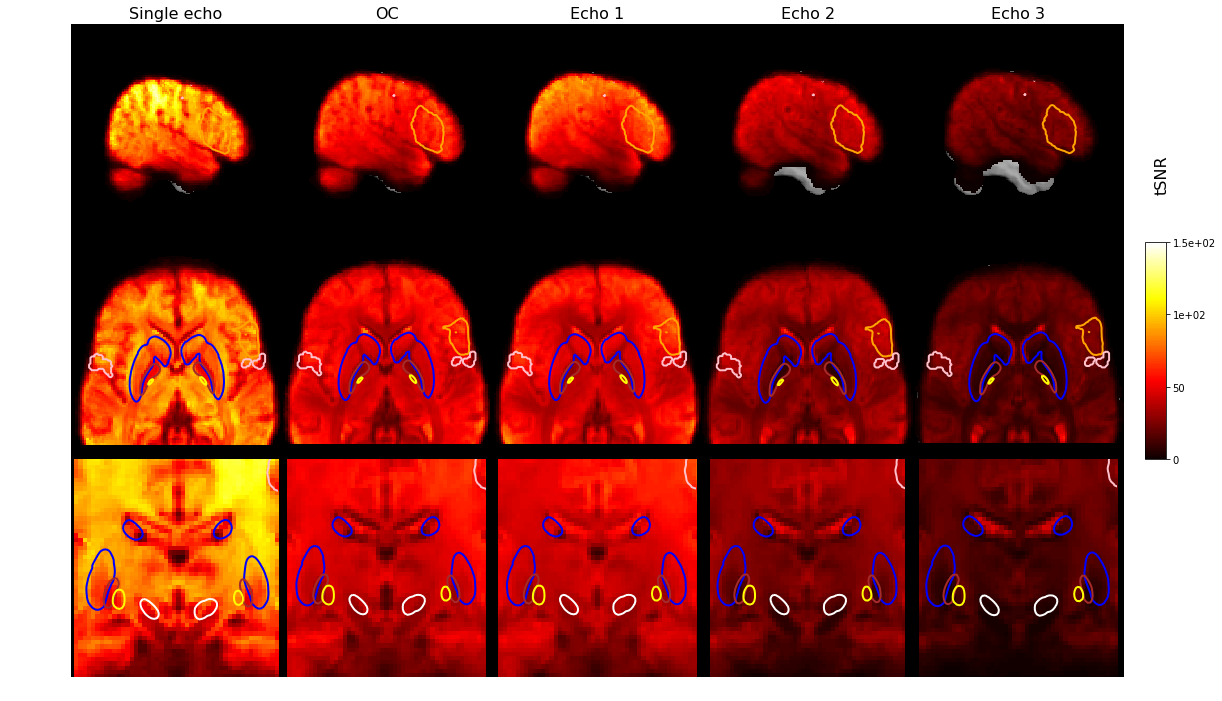

In [158]:
# plot
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(stat_maps, roi_dict=get_roi_dict(), z_threshold=0,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[52], None, [-13]],
                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                          vmax=150, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('OC', size=16)
axes[0,2].set_title('Echo 1', size=16)
axes[0,3].set_title('Echo 2', size=16)
axes[0,4].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)


# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=150, truncation_limits=(0,150), offset=0, flip=False)
#cbar_ax1.yaxis.set_label_position('right')
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('tSNR', rotation=90, fontsize=16, ha='left', pad=75)

# CNR analysis


In [260]:
subjectwise_cnrs = get_subjectwise_rois('cnr')

In [262]:
roiwise_cnr = subjectwise_cnrs.groupby(level=[0]).mean()[column_order]
roiwise_cnr = roiwise_cnr.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_cnr.index.name = 'Data type'
roiwise_cnr = roiwise_cnr.reindex(index = index_order)
roiwise_cnr.round(2)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN,lSTN
Data type,,,,,,,,
Single echo,1.30,1.22,1.15,1.01,0.77,0.82,0.84,0.83
Multi echo combined,1.33,1.40,1.28,0.81,0.46,0.51,0.53,0.54
Echo 1,0.69,0.65,0.63,0.43,0.31,0.31,0.33,0.34
Echo 2,1.01,1.05,0.98,0.57,0.27,0.31,0.36,0.36
Echo 3,1.00,1.10,0.96,0.49,0.22,0.26,0.25,0.25


In [263]:
roiwise_cnr_std = subjectwise_cnrs.groupby(level=[0]).std()[column_order]
roiwise_cnr_std = roiwise_cnr_std.rename(index={'echo_1': 'Echo 1', 'echo_2': 'Echo 2', 'echo_3': 'Echo 3', 'optcomb': 'Multi echo combined', 'se': 'Single echo'})
roiwise_cnr_std.index.name = 'Data type'
roiwise_cnr_std = roiwise_cnr_std.reindex(index = index_order)
roiwise_cnr_std.round(2)

,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN,lSTN
Data type,,,,,,,,
Single echo,0.22,0.19,0.22,0.15,0.13,0.12,0.12,0.12
Multi echo combined,0.18,0.18,0.20,0.09,0.05,0.07,0.05,0.05
Echo 1,0.07,0.06,0.08,0.04,0.04,0.04,0.04,0.04
Echo 2,0.11,0.11,0.14,0.07,0.04,0.05,0.04,0.03
Echo 3,0.12,0.15,0.16,0.07,0.02,0.03,0.03,0.03


In [162]:
wholebrain_cnr = get_wholebrain_niis('cnr')
stat_maps = wholebrain_cnr[['se', 'optcomb', 'echo_1', 'echo_2', 'echo_3']].values
len(stat_maps)

5

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels we

Text(0.5, 1.0, 'CNR')

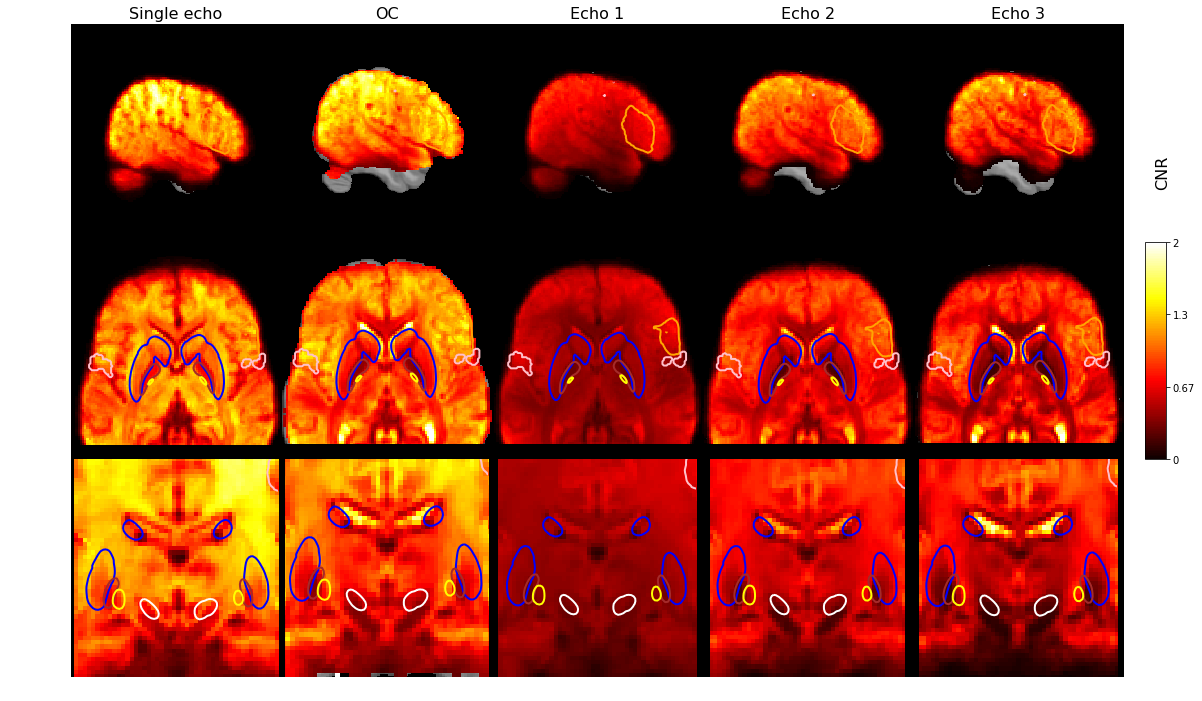

In [164]:
# plot
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(stat_maps, roi_dict=get_roi_dict(), z_threshold=0,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[52], None, [-13]],
                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                          vmax=2, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('OC', size=16)
axes[0,2].set_title('Echo 1', size=16)
axes[0,3].set_title('Echo 2', size=16)
axes[0,4].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)


# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=2, truncation_limits=(0,2), offset=0, flip=False)
#cbar_ax1.yaxis.set_label_position('right')
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('CNR', rotation=90, fontsize=16, ha='left', pad=75)

In [32]:
subjectwise_tsnrs.groupby(level=[0]).mean()[column_order]
#subjectwise_tsnrs.groupby(level=[0]).std()


,rM1,rPreSMA,rIFG,rSTR,rGPe,rGPi,rSTN
data_type,,,,,,,
echo_1,72.375105,66.908856,65.697773,44.775172,32.029751,32.357249,34.552120
echo_2,41.617718,42.901179,40.371186,23.192646,10.894259,12.460984,14.295457
echo_3,27.664277,30.169954,28.712320,21.209304,10.078508,10.573773,7.987479
optcomb,60.263584,60.249670,58.036967,43.474429,31.537373,32.526586,34.577442
se,90.675193,86.478762,81.298308,71.940610,55.261388,58.395545,59.697129


In [ ]:
# atlas with attributes
from utils import load_atlas
atlas = load_atlas()

# roiwise_df = make_roiwise_df(atlas=atlas, dep_var='tsnr', data_types=['se', 'optcomb', 'optcomb-den', 'echo_1', 'echo_2', 'echo_3'])
roiwise_df_long = make_roiwise_df(atlas=atlas, 
                                  dep_var='tsnr', 
                                  data_types=['se', 'optcomb', 'optcomb-den', 'echo_1', 'echo_2', 'echo_3'], 
                                  df_type='long')

se


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


optcomb
optcomb-den


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


echo_1
echo_2
echo_3


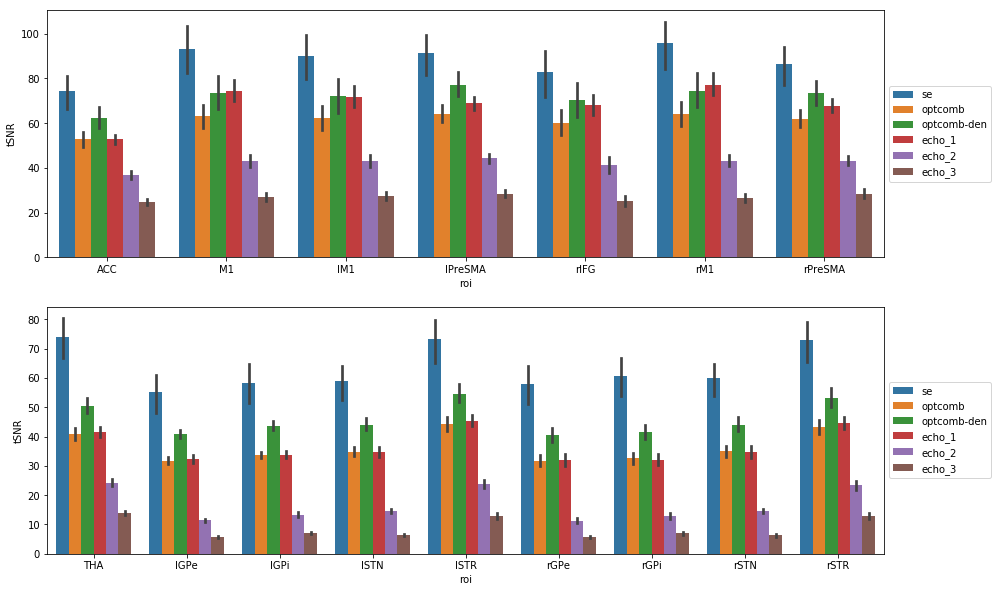

In [34]:
f, ax = plt.subplots(2,1)
sns.barplot('roi', 'tSNR', 'data_type', ax=ax[0], data=roiwise_df_long.loc[roiwise_df_long.cort=='cortex'])
sns.barplot('roi', 'tSNR', 'data_type', ax=ax[1], data=roiwise_df_long.loc[roiwise_df_long.cort=='subcortex'])
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.gcf().set_size_inches(15,10)

In [35]:
aggr = roiwise_df.reset_index().groupby(['data_type'])[labels_list].mean()
np.round(aggr, decimals=1).to_csv('/home/stevenm/Desktop/tsnr.csv')
aggr

NameError: name 'labels_list' is not defined

In [449]:
# from IPython.display import FileLink
# FileLink('/home/stevenm/Desktop/tsnr.csv')

/home/stevenm/Desktop/tsnr.csv

## Plot mean voxelwise tSNR

In [7]:
from utils import *

In [ ]:
tsnr_maps = [mean_img(get_all_tsnrs('se')), mean_img(get_all_tsnrs('optcomb')), 
             mean_img(get_all_tsnrs('optcomb-den')), mean_img(get_all_tsnrs('echo_1')), 
             mean_img(get_all_tsnrs('echo_2')), mean_img(get_all_tsnrs('echo_3'))]
tsnr_maps

In [ ]:
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(stat_maps, roi_dict=get_roi_dict(), z_threshold=0,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[52], None, [-13]],
                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                          vmax=150, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4, 5),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('OC', size=16)
axes[0,2].set_title('OC denoised', size=16)
axes[0,3].set_title('Echo 1', size=16)
axes[0,4].set_title('Echo 2', size=16)
axes[0,5].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)


# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0, vmax=150, truncation_limits=(0,150), offset=0, flip=False)
#cbar_ax1.yaxis.set_label_position('right')
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('tSNR', rotation=90, fontsize=16, ha='left', pad=75)

# Theoretical CNR
Single echo: 

$CNR = \frac{S\cdot TE}{\sigma}$

Multi echo:

$C = w \cdot S \cdot TE$

$\sigma = std(combined)$

In [67]:
def make_CNR_map(sub, ses, run=1, echo_n=None, combmode=None, denoised=False, save=True,
                 tes_me = [0.00966, 0.02487, 0.04008], te_se = 0.014):
    
    if (ses == 'se') or (ses == 'me' and echo_n is not None):
        hdr_fn, mask_fn = get_fn(sub, ses, run, echo_n, combmode, denoised=denoised)
        tsnr_fn = hdr_fn.replace('_bold', '_tsnr')
        
        if echo_n is not None:
            te = tes_me[echo_n-1]
        else:
            te = te_se
        cnr = index_img(tsnr_fn, 0).get_data()*te
        cnr[cnr<0] = 0
        cnr = nib.Nifti1Image(cnr, affine=nib.load(hdr_fn).affine)
        # save
        nib.save(cnr, hdr_fn.replace('_bold', '_cnr'))
    elif ses == 'me' and combmode == 'optcomb':
        # get contrasts
        echos = [get_fn(sub, 'me', echo_n=x)[0] for x in [1,2,3]]
        echos_contrast = [mean_img(echos[x-1]).get_data()*tes_me[x-1] for x in [1,2,3]]
        
        # load t2s-map
        t2s = nib.load('./data/deriv/fmriprep/sub-{}/ses-me/func/sub-{}_ses-me_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp-t2svG_bold.nii.gz'.format(str(sub).zfill(2), str(sub).zfill(2)))
        t2s_dat = t2s.get_data()
        
        # get weights (optcomb method)
        weights = [tes_me[x-1]*np.exp(-tes_me[x-1]/t2s_dat) for x in [1,2,3]]
        weights_normalized = weights/np.sum(np.array(weights), axis=0)

        # weight each individual contrast
        echos_weighted = [echos_contrast[x]*weights_normalized[x,:,:,:] for x in [0,1,2]]        
        contrast = np.sum(np.array(echos_weighted), axis=0)
        
        # get noise term
        hdr_fn, mask_fn = get_fn(sub, 'me', run=1, echo_n=None, combmode='optcomb')
        tsnr_fn = hdr_fn.replace('_bold', '_tsnr')
        noise = index_img(nib.load(tsnr_fn), 2)
        cnr = nib.Nifti1Image(contrast / noise.get_data(), affine=t2s.affine)
        nib.save(cnr, hdr_fn.replace('_bold', '_cnr'))
        # save
    return cnr

In [68]:
import multiprocessing as mp
import itertools
subs = [x for x in np.arange(1, 19) if not x == 12]
ses = ['se', 'optcomb', 1, 2, 3]
to_run = list(itertools.product(subs, ses))
# to_run

In [69]:
def mp_helper(to_run):
    sub, ses = to_run
    print('{} {}'.format(sub, ses))
    if ses == 'se':
        make_CNR_map(sub, ses)
    elif ses == 'optcomb':
        make_CNR_map(sub, ses='me', combmode='optcomb')
    else:
        make_CNR_map(sub, ses='me', echo_n=ses)
        
with mp.Pool(15) as p:
    p.map(mp_helper, to_run)

1 se
1 1
2 optcomb
1 3
2 2
4 optcomb
4 2
3 1
6 optcomb
5 3
5 1
3 se
6 2
3 3
5 se
1 optcomb
1 2
2 se
2 3
6 3
4 3
4 se
7 se
5 2
5 optcomb
6 se
7 1
7 3
3 optcomb
3 2
8 optcomb
8 2
9 se
7 optcomb
9 1
8 se
9 3
7 2
9 optcomb
10 optcomb
8 3
10 2
9 2
10 se
11 se
10 3
11 1
11 3
13 optcomb
13 2
11 optcomb
11 2
13 se
13 3
14 se
14 1
14 3
14 2
15 se
14 optcomb
15 optcomb
15 2
15 3
16 se
16 optcomb


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


16 1
16 2


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


16 3
2 1
17 optcomb
17 se
17 2
17 3
18 se
18 optcomb


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


18 1
18 2
18 3


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


8 1


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


6 1


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


4 1


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


15 1


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


10 1


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


13 1
17 1


In [7]:
def get_all_cnrs(data_type):
    all_imgs = []
    for sub in np.arange(1, 19):
        if sub == 12:
            continue
        if data_type == 'se':
            bold, mask = get_fn(sub, 'se', run=1)
        elif data_type == 'optcomb':
            bold, mask = get_fn(sub, 'me', combmode='optcomb', run=1)
        elif data_type == 'PAID':
            bold, mask = get_fn(sub, 'me', combmode='PAID', run=1)
        elif data_type == 'echo_1':
            bold, mask = get_fn(sub, 'me', echo_n=1, run=1)
        elif data_type == 'echo_2':
            bold, mask = get_fn(sub, 'me', echo_n=2, run=1)
        elif data_type == 'echo_3':
            bold, mask = get_fn(sub, 'me', echo_n=3, run=1)
        elif data_type == 'optcomb-den':
            bold, mask = get_fn(sub, 'me', denoised=True, combmode='optcomb', run=1)
        elif data_type == 'echo_1-den':
            bold, mask = get_fn(sub, 'me', denoised=True, echo_n=1, run=1)
        elif data_type == 'echo_2-den':
            bold, mask = get_fn(sub, 'me', denoised=True, echo_n=2, run=1)
        elif data_type == 'echo_3-den':
            bold, mask = get_fn(sub, 'me', denoised=True, echo_n=3, run=1)

        cnr = bold.replace('_bold', '_cnr')
        all_imgs.append(cnr)
        
    return concat_imgs(all_imgs)

In [9]:
cnr_maps = [mean_img(get_all_cnrs('se')), mean_img(get_all_cnrs('optcomb')), 
            mean_img(get_all_cnrs('echo_1')), mean_img(get_all_cnrs('echo_2')), mean_img(get_all_cnrs('echo_3'))]
cnr_maps

In [11]:
from utils import *

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels we

Text(0.5, 1.0, 'CNR')

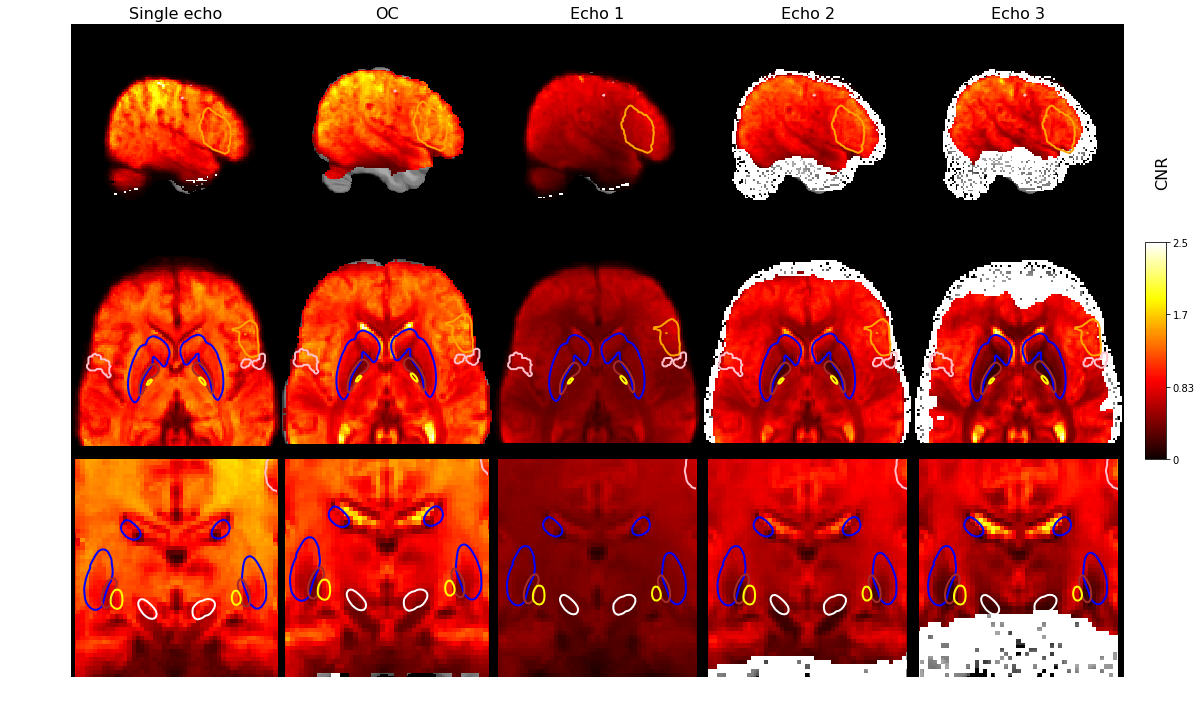

In [14]:
from matplotlib import gridspec
gridspec_kws = dict(hspace=0.0, wspace=0.0, 
                width_ratios=[1, 1, 1, 1, 1, .1, .1, .1])
gs = gridspec.GridSpec(3, len(stat_maps)+3, **gridspec_kws)
f, axes = plt.subplots(3, len(stat_maps)+3, gridspec_kw=gridspec_kws)  
# add 5 columns: 3 interspaces, 2 colorbars

f, axes, disps = plot_spm(stat_maps, roi_dict=get_roi_dict(), z_threshold=0,
                          f=f, axes=axes,
                          roi_to_plot=['rIFG', 'STR', 'STN'],
                          cut_coords=[[52], None, [-13]],
                          bg_img='/home/stevenm/Templates/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii',
                          vmax=2.5, #colorbar=False, 
                          plot_columns=(0, 1, 2, 3, 4),
                          annotate=False, empty_plots=False, 
                          skip_all_but_last=False)
axes[0,0].set_title('Single echo', size=16)
axes[0,1].set_title('OC', size=16)
axes[0,2].set_title('Echo 1', size=16)
axes[0,3].set_title('Echo 2', size=16)
axes[0,4].set_title('Echo 3', size=16)

for row in range(axes.shape[0]):
#     axes[row,2].set_visible(False)
#     axes[row,5].set_visible(False)
#     axes[row,8].set_visible(False)
    if row in [0,1,2]:
        for col in [-3,-2,-1]:
            axes[row,col].set_visible(False)
            axes[row,col].set_visible(False)


# colormap legend
cbar_ax1 = f.add_subplot(gs[1,-2])
cbar_ax1 = draw_custom_colorbar(colorbar_ax=cbar_ax1, vmin=0,
                                vmax=2.5, truncation_limits=(0,2.5), offset=0, flip=False)
#cbar_ax1.yaxis.set_label_position('right')
cbar_ax1.yaxis.set_ticks_position('right')
cbar_ax1.set_title('CNR', rotation=90, fontsize=16, ha='left', pad=75)

In [59]:
cnr = make_CNR_map(sub=2, ses='me', combmode='optcomb')

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


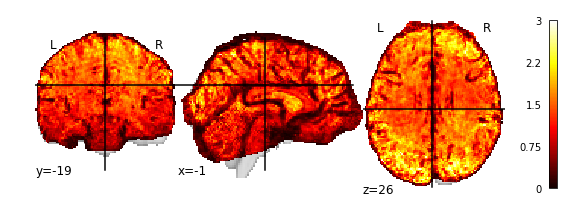

In [66]:
cnr_se = make_CNR_map(sub=2, ses='se')
plotting.plot_stat_map(cnr_se, vmax=3)

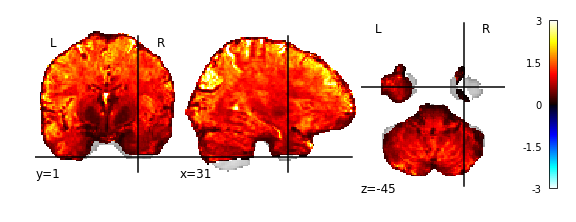

In [61]:
plotting.plot_stat_map(cnr, vmax=3)

In [36]:
all_niftis = get_all_tsnrs('se')

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


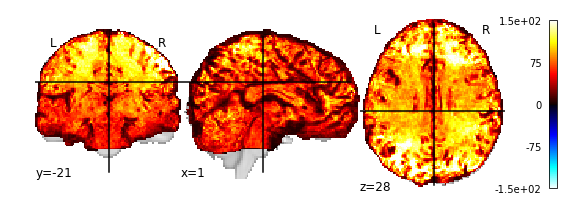

In [41]:
plotting.plot_stat_map(index_img(all_niftis, 0), vmax=150)

In [118]:
e1 = nib.load(get_fn(1, 'me', echo_n=1)[0])
c1 = nib.Nifti1Image(e1.get_data().mean(3)*0.00966, e1.affine)

e2 = nib.load(get_fn(1, 'me', echo_n=2)[0])
c2 = nib.Nifti1Image(e2.get_data().mean(3)*0.02487, e1.affine)

e3 = nib.load(get_fn(1, 'me', echo_n=3)[0])
c3 = nib.Nifti1Image(e3.get_data().mean(3)*0.04008, e1.affine)

In [49]:
t2s = nib.load('./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp-t2svG_bold.nii.gz')
t2s_dat = t2s.get_data()

In [117]:
np.nanmean(np.sum(weights, axis=0))

1.0

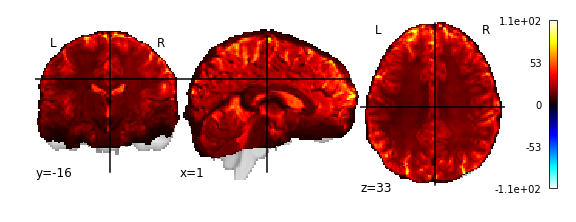

In [119]:
contrst = c1.get_data()*weights[0] + c2.get_data()*weights[1] + c2.get_data()*weights[2]
plotting.plot_stat_map(nib.Nifti1Image(contrst, affine=e1.affine))

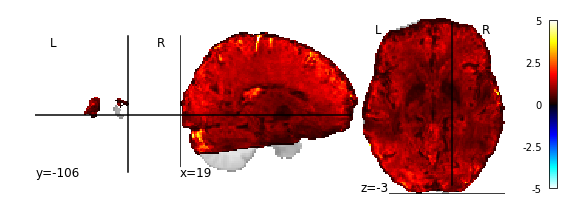

In [125]:
cnr = contrst/noise.get_data()


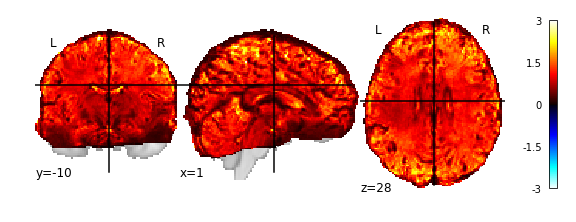

In [129]:
cut_coords = [1, -10, 28]
plotting.plot_stat_map(nib.Nifti1Image(cnr, affine=e1.affine), vmax=3, cut_coords=cut_coords)

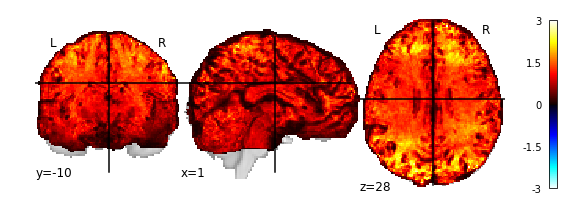

In [128]:
plotting.plot_stat_map(nib.Nifti1Image(index_img(all_niftis, 0).get_data()*0.014, affine=e1.affine), 
                       vmax=3, cut_coords=cut_coords)

In [ ]:
!ls ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_tsnr.nii.gz

In [112]:
# noise term
noise = nib.load('./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_tsnr.nii.gz')
noise = index_img(noise, 2)

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


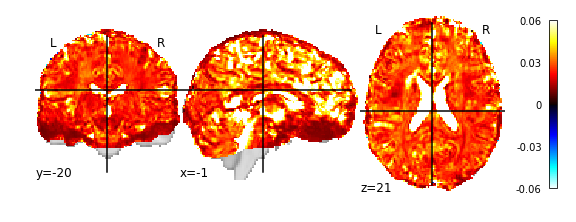

In [98]:
plotting.plot_stat_map(t2s, vmax=0.06)

In [99]:
tes = np.array([0.00966, 0.02487, 0.04008])
w1 = tes[0]*np.exp(-tes[0]/t2s_dat)
w2 = tes[1]*np.exp(-tes[1]/t2s_dat)
w3 = tes[2]*np.exp(-tes[2]/t2s_dat)

W = w1+w2+w3
weights = np.array([w1/W, w2/W, w3/W])

# #s = np.average(e1.get_data(), e2.get_data(), e3.get_data(), weights=).sum(axis=3)
# w1 /= s
# w2 /= s
# w3 /= s

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


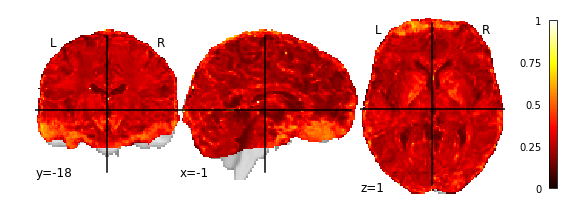

In [104]:
plotting.plot_stat_map(nib.Nifti1Image(weights[0], affine=t2s.affine), vmax=1)

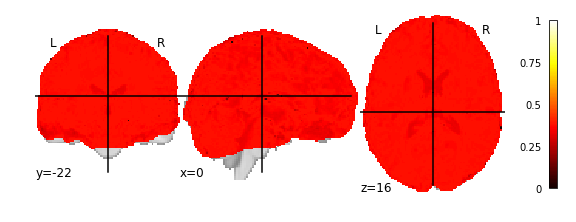

In [103]:
plotting.plot_stat_map(nib.Nifti1Image(weights[1], affine=t2s.affine), vmax=1)

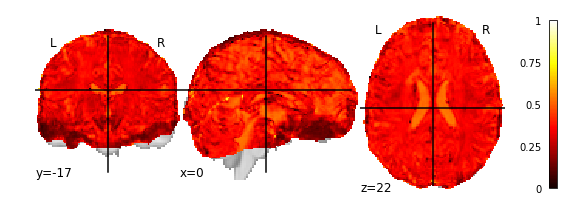

In [105]:
plotting.plot_stat_map(nib.Nifti1Image(weights[2], affine=t2s.affine), vmax=1)

# Theoretical contrast-to-noise ratios
Based on Posse, 1999; Gowland & Bowtell, 2007; Poser, 2006

### Single-echo CNR ( = Multi-Echo CNR with simple summation of echos)
(G&B07, Eq 2)
$CNR = -\frac{S_0}{\sigma_0 \sqrt{N}} \Delta R_{2}^* \delta \sum_{j=1}^{N}(2j-1)\exp{-\delta(2j-1)R_{2}^*}$  

where: 

- $S_0$, $\sigma_0$ is signal, noise immediately after excitation;
- $\Delta R_{2}^*$ is the change in $R_2^*$ due to BOLD-response (assumed to be small)
- $\delta$ is the first echo time (TE difference = 2delta)
- $N$ is the number of echos, such that if N=1:

$CNR = -\frac{S_0}{\sigma_0} * TE * \Delta R_{2}^* \exp{-TE* R_{2}^*}$

Assuming $\Delta R_{2}^*$ is small (Posse, 1999), the maximum BOLD-contrast is:

$CNR_{max} = 0.37 \frac{S_0 \Delta T_2^*(t_r)}{T_2^*}$

The corresponding unit is $\frac{S_0 \Delta R_2^*}{\sigma_0 R_2^*}$

0.36787944117144233

Text(0, 0.5, 'CNR single echo ($\\frac{S_0\\Delta_R^*}{\\sigma_0 R_2^*}$)')

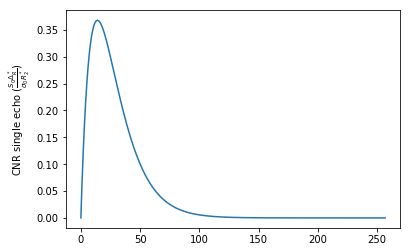

In [362]:
def cnr_single_echo(s0, std0, te, delta_R2s, t2s):
    delta_t2s_tr = t2s + (1/delta_R2s)
    
    return (s0/std0) * (te/t2s) * np.exp(-te/t2s)


tes = np.arange(0, 258, 1)
t2s = 14
cnrs = cnr_single_echo2(s0=1, std0=1, te=tes, delta_R2s=1, t2s=t2s)
plt.plot(tes, cnrs)
plt.ylabel('CNR single echo ($\\frac{S_0\Delta_R^*}{\sigma_0 R_2^*}$)')

### Multi-echo CNR
Bowtell & Gowland 2007, Eq. 6 (assuming weighted summing of echos)

$CNR = \frac{S_0}{\sigma_0} \Delta R_2^* \delta \sqrt{\sum_{j=1}^N (2j-1)^2 \exp{-2 \delta (2j-1) R_2^*}}$

where

- $S_0$, $\sigma_0$ is signal, noise immediately after excitation;
- $\Delta R_{2}^*$ is the change in $R_2^*$ due to BOLD-response (assumed to be small)
- $\delta$ is the first echo time (TE difference = 2delta)
- $N$ is the number of echos (j = echo number):



### Much simpler

Poser, 2006

By multiplying the echo time with the signal-to-noise ratio (tSNR), you get an estimate of the expected CNR

Such that, for the single-echo case:

$CNR = \frac{-S \cdot TE}{\sigma}$

where
$S = S_0 \cdot H(TE) \cdot \exp{-TE \cdot R_{2(BOLD)}^*}$

[H(.)?] some noise term?

And for the multi-echo case:

$wCNR = \frac{SNR_n \cdot TE_n}{\sum_{n=1}^N SNR_n \cdot TE_n}$

In [395]:
dte2 = 40.08-9.66
dte1 = 24.87-9.66

In [398]:
cnr_me[0]

array([0.        , 6.31128034, 9.15804679])

Text(0.5, 0, 'TE (assuming T2*=15)')

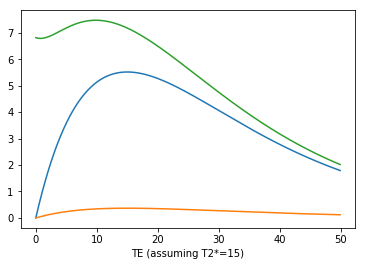

In [423]:
def t2s_decay(s0, t2s, te):
    
    return s0*np.exp(-te/t2s)
    
def multi_echo_cnr(tsnr, te):
    # tsnr = list-like of tsnrs per echo
    # te = list-like of tes of each echo
    tsnr = np.array(tsnr)
    te = np.array(te)

    weights = (tsnr*te) / np.sum(tsnr*te)
#     print(weights)
    return np.average(tsnr*te, weights=weights)/np.sqrt(np.sum(weights**2))

def multi_echo_cnr2(tes, t2s):
    
    s0 = np.exp(-tes/t2s)
    weights = tes * s0
    weights = weights/np.sum(weights)
    
    cnr = np.sum(weights*tes*s0) / np.sqrt(np.sum(weights**2))
    return cnr

t2s = 15
tes = np.arange(0, 50, 0.1)

cnr_me = []
for tes_ in tes:
    cnr_me.append(multi_echo_cnr2(np.array([tes_, tes_+dte1, tes_+dte2]), t2s=t2s))
# plt.plot(tes, t2s_decay(1, t2s, tes))
plt.plot(tes, t2s_decay(1, t2s, tes)*tes)
plt.plot(tes, cnr_single_echo2(s0=1, std0=1, te=tes, delta_R2s=1, t2s=t2s))
plt.plot(tes, cnr_me)
plt.xlabel('TE (assuming T2*=15)')

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 0, 'Middle TE (assuming T2*=15)')

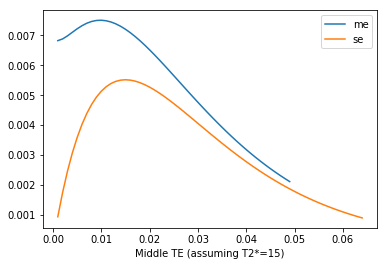

In [334]:
# ME?
t2s = .015
tes_mid = np.arange(0, .065, .001)
delta_te = .015

cnr_me = []
cnr_se = []
for te_mid in tes_mid:
    if te_mid <= t2s:
        cnr_me.append(np.nan)
    else:
        tes = np.array([te_mid-delta_te, te_mid, te_mid+delta_te])
        tsnr_ = t2s_decay(1, t2s, tes)
        cnr_me.append(multi_echo_cnr(tsnr_, tes))

    cnr_se.append(multi_echo_cnr(t2s_decay(1, t2s, te_mid), te_mid))

plt.plot(tes_mid-0.015, cnr_me, label='me')
plt.plot(tes_mid, cnr_se, label='se')
plt.legend()

# plt.plot(tes, t2s_decay(1, t2s, tes)*tes)
# plt.plot(tes, cnr_single_echo2(s0=1, std0=1, te=tes, delta_R2s=0.00479, t2s=t2s))
plt.xlabel('Middle TE (assuming T2*=15)')

In [268]:
t2s_decay(1, t2s, te_se)

0.751477293075286

In [269]:
te_se

14

In [277]:
multi_echo_cnr(t2s_decay(1, .2, te_se), te_se)

1.0


3.975449735908647e-31

[nan nan nan]
nan
[9.99999362e-01 6.38380058e-07 2.55101005e-13]
1.0
[9.98718612e-01 1.28036050e-03 1.02748304e-06]
1.0
[9.83924577e-01 1.59142965e-02 1.61126268e-04]
1.0
[0.94382668 0.05422332 0.00194999]
1.0
[0.88310951 0.1085399  0.0083506 ]
1.0
[0.8129234  0.16588678 0.02118982]
1.0
[0.74244741 0.21762285 0.03992975]
1.0
[0.67696805 0.26035412 0.06267784]
1.0
[0.6186905  0.29391005 0.08739945]
1.0
[0.56799073 0.31950525 0.11250402]
1.0
[0.52435445 0.33869812 0.13694743]
1.0
[0.48693014 0.3529369  0.16013296]
1.0
[0.45481002 0.36341608 0.1817739 ]
1.0
[0.42715384 0.3710676  0.20177857]
1.0
[0.403232  0.3765989 0.2201691]
1.0
[0.38243096 0.38054017 0.23702887]
1.0
[0.36424294 0.38328689 0.25247017]
1.0
[0.34825075 0.38513402 0.26661524]
1.0
[0.33411235 0.38630206 0.27958559]
1.0
[0.32154704 0.38695656 0.2914964 ]
1.0
[0.31032379 0.38722238 0.30245383]
1.0
[0.30025172 0.38719412 0.31255415]
1.0
[0.29117236 0.38694387 0.32188377]
1.0
[0.28295349 0.38652678 0.33051973]
1.0
[0.27548425 0

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


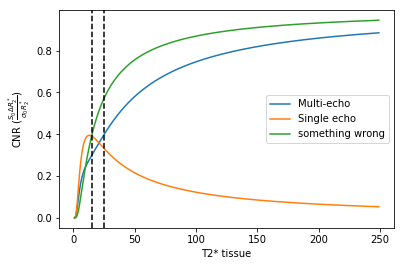

In [279]:
te_mid = 10
delta_tes = 10
#s0s = t2s_decay(1, 15, np.array(tes))
t2s_tissue = 25

tes_me = np.array([9.66, 24.87, 40.08])
te_se = 14

#te_mids = np.arange(10, 50, 1)
t2s_tissues = np.arange(0, 250, 1)
cnrs_me = []
cnrs_se = []
for t2s in t2s_tissues:
    cnrs_me.append(multi_echo_cnr(t2s_decay(1, t2s, np.array(tes_me)), 
                                  np.array(tes_me)))
    
    cnrs_se.append(multi_echo_cnr(t2s_decay(1, t2s, te_se), te_se))
    
plt.plot(t2s_tissues, cnrs_me, label='Multi-echo')
plt.plot(t2s_tissues, cnr_single_echo2(s0=1, std0=1, te=te_se, delta_R2s=1, t2s=t2s_tissues), label='Single echo')
plt.plot(t2s_tissues, cnrs_se, label='something wrong')
plt.xlabel('T2* tissue')
plt.ylabel('CNR ($\\frac{S_0 \Delta R_2^*}{\sigma_0 R_2^*}$)')
plt.legend()

plt.axvline(15, linestyle='--', color='black')
plt.axvline(25, linestyle='--', color='black')

In [186]:
1/30

0.03333333333333333

In [281]:
t2s_decay(1, t2s, np.array(tes_me))

array([0.52518747, 0.19051964, 0.06911386])

In [284]:
t2s_tmp = 25
tes_tmp = [5, 20, 35]
multi_echo_cnr(t2s_decay(1, t2s_tmp, np.array(tes_tmp)), 
               np.array(tes_tmp))

0.4383873244306697

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in multiply
  


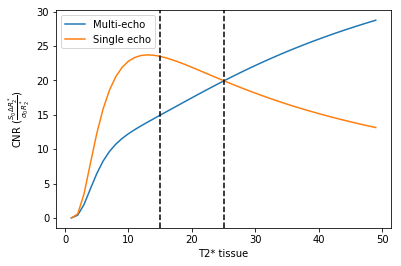

In [188]:
# Multiply both functions by measured tSNR

tes_me = np.array([9.66, 24.87, 40.08])
te_se = 14

tSNR_se = 60  # lSTN
tSNR_me = np.array([36, 15, 6])

#te_mids = np.arange(10, 50, 1)
t2s_tissues = np.arange(0, 50, 1)
cnrs = []
for t2s in t2s_tissues:
    cnrs.append(multi_echo_cnr(t2s_decay(1, t2s, np.array(tes_me)), 
                               np.array(tes_me), noise=1/50))
#    cnrs.append(multi_echo_cnr(tSNR_me, tes_me))

plt.plot(t2s_tissues, cnrs, label='Multi-echo')
plt.plot(t2s_tissues, cnr_single_echo2(s0=60, std0=1, te=te_se, delta_R2s=1, t2s=t2s_tissues), label='Single echo')
plt.xlabel('T2* tissue')
plt.ylabel('CNR ($\\frac{S_0 \Delta R_2^*}{\sigma_0 R_2^*}$)')
plt.legend()

plt.axvline(15, linestyle='--', color='black')
plt.axvline(25, linestyle='--', color='black')

## Load t2*-values of tissue

In [194]:
!ls ./lcat_denoising

sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-den.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-dim.nii.gz
sub-01_ses-me_task-stop_run-1_echo-1_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-res.nii.gz
sub-01_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-2_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-den.nii.gz
sub-01_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz
sub-01_ses-me_task-stop_run-1_echo-3_space-MNI152NLin2009cAsym_desc-preproc-hp_bold_lcat-den.nii.gz
sub-01_ses-me_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_bold_lcat-den.nii.gz
sub-01_ses-me_task-stop_run-1_space-MNI152NLin2009cAsym_desc-preproc-hp-optcomb_tsnr_lcat-den.nii.gz
sub-01_ses-me_task-stop_r

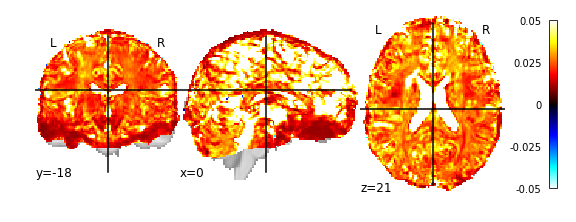

In [205]:
#s0map = nib.load(get_fn(1, 'me', run=1, denoised=True)[0].replace('optcomb', 's0vG'))
t2smap = nib.load(get_fn(1, 'me', run=1, denoised=True)[0].replace('optcomb', 't2svG'))
plotting.plot_stat_map(t2smap, vmax=0.05)

In [235]:
voxelwise_t2s = make_data_df(atlas=atlas, data_types=['me-den'], dep_var='t2s')

me-den


In [251]:
# reshape df for plotting
voxelwise_df2 = voxelwise_df.reset_index().melt(id_vars=['subject_index', 'data_type'], 
                                                value_vars=labels_list, value_name='tSNR')

# add info on cortex/subcortex
cortex_set = {'lM1', 'rM1', 'M1', 'PreSMA', 'lPreSMA', 'rPreSMA', 'ACC', 'rIFG'}
voxelwise_df2['cort'] = voxelwise_df2['roi'].apply(lambda x: 'cortex' if x in cortex_set else 'subcortex')

In [249]:
# voxelwise_t2s.reset_index().melt(id_vars=['subject_index', 'data_type'], 
#                                                     value_vars=labels_list, value_name='t2s')

In [258]:
voxelwise_df2 = pd.merge(voxelwise_df2, voxelwise_t2s.reset_index().melt(id_vars=['subject_index', 'data_type'], 
                                                        value_vars=labels_list, value_name='t2s')[['subject_index', 'roi', 't2s']], 
                         on=['subject_index', 'roi'])

In [260]:
voxelwise_df2['cnr'] = np.nan
voxelwise_df2.loc[voxelwise_df2['data_type']=='se', 'cnr'] = voxelwise_df2.loc[voxelwise_df2['data_type']=='se', 't2s']*15
voxelwise_df2

,subject_index,data_type,roi,tSNR,cort,t2s,cnr
0,0,se,ACC,67.432571,cortex,0.040300,0.604497
1,0,optcomb,ACC,47.297581,cortex,0.040300,NaN
2,0,me-den,ACC,54.784885,cortex,0.040300,NaN
3,0,echo_1,ACC,48.949066,cortex,0.040300,NaN
4,0,echo_2,ACC,33.769596,cortex,0.040300,NaN
5,0,echo_3,ACC,22.785925,cortex,0.040300,NaN
6,1,se,ACC,86.225029,cortex,0.042549,0.638229
7,1,optcomb,ACC,57.289082,cortex,0.042549,NaN
8,1,me-den,ACC,67.661057,cortex,0.042549,NaN
9,1,echo_1,ACC,56.008850,cortex,0.042549,NaN


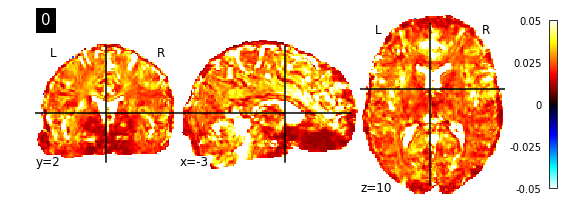

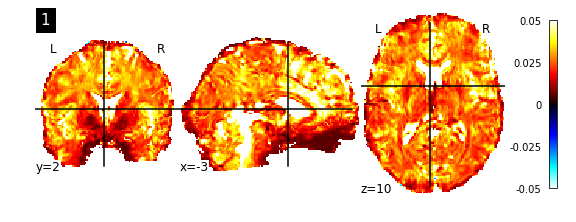

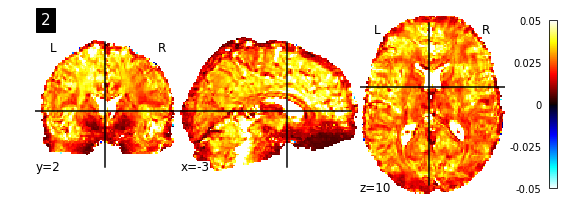

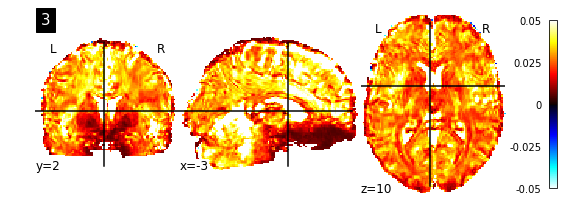

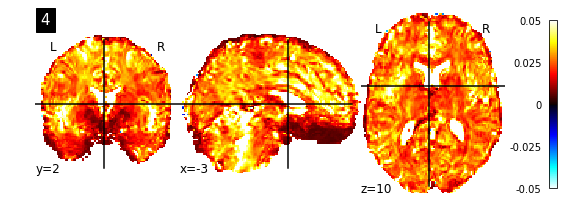

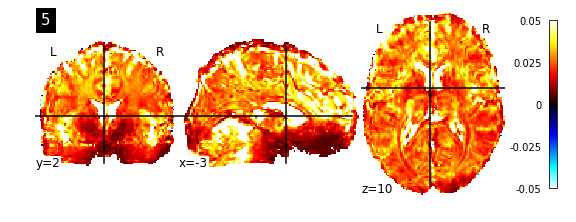

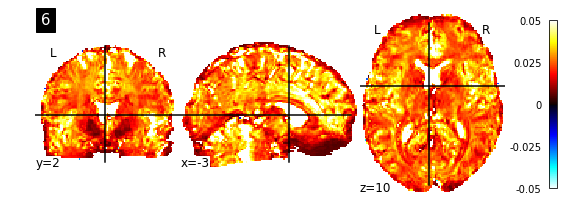

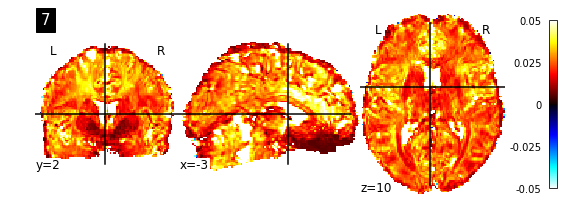

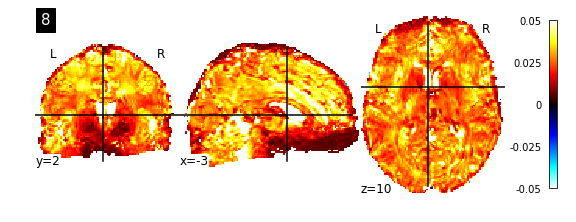

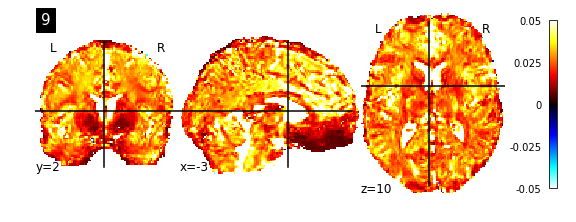

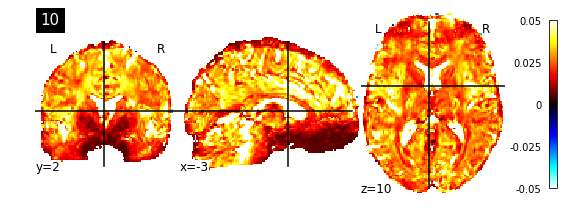

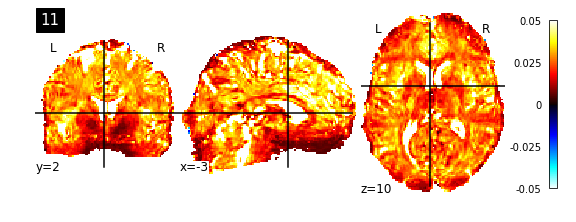

In [211]:
data = get_all_tsnrs(data_type='me-den', output_type='t2s')
for sub in np.arange(data.shape[-1]):
    plotting.plot_stat_map(index_img(data, sub), bg_img=None, vmax=0.05, cut_coords=[-3, 2, 10], title=sub)

In [212]:
data

# ROI-wise
Create mean timeseries within a mask (weighted by probability), then calculate tSNR

In [25]:
def combine_masks(probseg, brain_mask):
    if isinstance(probseg, str):
        probseg = nib.load(probseg)
    if isinstance(brain_mask, str):
        brain_mask = nib.load(brain_mask)
    
    probseg_data = probseg.get_data()
    mask_data = brain_mask.get_data()
    probseg_data[mask_data==0] = 0
    
    return nib.Nifti1Image(probseg_data, probseg.affine)

# new_map = combine_masks(probseg, mask_fn)

In [66]:
all_tsnrs = []
t_r = 3

for sub in np.arange(1, 19):
    print(sub)
    if sub == 12:
        continue

    bold_fn, mask_fn = get_fn(sub, 'se')
    
    # apply brain mask to atlas prob maps to prevent any out-of-brain voxels to weigh in
    maps_new = []
    for map_idx in np.arange(atlas.maps.shape[-1]):
        maps_new.append(combine_masks(index_img(atlas.maps, map_idx), mask_fn))
    prob_maps = image.concat_imgs(maps_new)
    
    ## NiftiLabelMasker
    masker = NiftiMapsMasker(prob_maps,
                             mask_img=None,
                             standardize=False,
                             detrend=False,
                             low_pass=None,
                             high_pass=None)

    data = nib.load(bold_fn)
    # get tsnr from multi-volume
    results = masker.fit_transform(data)

    # For weird atlases that have a label for the background
    if len(atlas.labels) == results.shape[1] + 1:
        atlas.labels = atlas.labels[1:]

    index = pd.Index(np.arange(0, t_r*data.shape[-1], t_r), name='time')
    columns = pd.Index(atlas.labels, name='roi')

    timecourses = pd.DataFrame(results, index=index, columns=columns)
    tsnr = timecourses.mean(0)/timecourses.std(0)
    all_tsnrs.append(tsnr)

1


/home/stevenm/miniconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:301: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if self.memory_level == 0 and self.memory.cachedir is not None:


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


In [67]:
pd.concat(all_tsnrs, 1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
roi,,,,,,,,,,,,,,,,,
ACC,213.059573,315.917178,284.129285,446.142188,251.458801,293.900900,187.508126,365.246666,216.814863,150.344831,116.919600,174.543554,313.364160,315.348503,270.313411,198.441083,404.118512
M1,241.565031,348.828008,275.805636,467.998591,279.899917,316.623045,171.984587,386.494017,185.148139,181.949459,75.395866,163.603291,324.927189,128.838097,466.686221,178.043649,542.560547
lGPe,187.250131,200.667406,73.414606,298.382517,204.618793,215.514764,150.676617,236.974171,157.324895,152.082252,95.191138,161.786094,224.512077,172.083392,317.164568,208.911774,289.729595
lGPi,190.246576,191.477242,115.462801,215.245555,165.446517,266.428449,145.826544,197.159195,99.404990,73.221539,75.046410,164.180879,188.806463,160.291886,234.588736,132.815449,219.606098
lM1,172.072822,320.131887,-275.805636,392.084080,234.130303,323.629724,147.957179,393.712227,153.024157,161.444911,-75.395866,-163.603291,317.397696,-128.838097,376.529579,195.784219,525.359276
lPreSMA,211.299369,350.559461,269.209686,366.193453,290.494344,338.828182,197.459691,373.150763,209.334462,163.441250,114.396921,215.174534,355.082023,325.416182,275.182322,236.711039,541.176866
lSTN,112.932114,119.049861,156.074001,167.611306,139.004925,137.423157,141.799353,210.226116,110.866208,97.941073,70.672296,133.636656,116.931379,109.542303,224.730704,132.328181,167.820265
lSTR,206.190360,240.237710,242.593551,247.941635,244.972134,206.725514,165.820320,296.757519,167.412983,146.041506,156.472849,156.253521,224.655672,209.918153,307.718253,138.312442,341.212226
rGPe,143.785535,131.281692,319.685551,266.664499,232.363404,280.639652,112.640102,238.081297,197.816418,169.087439,78.535978,243.972681,282.155237,169.139573,341.605099,197.415626,234.610728


In [45]:
tmp = pd.DataFrame(results, index=index, columns=columns)
tmp.mean(0)/tmp.std(0)

roi
ACC        206.865831
M1         252.869566
lGPe       189.152193
lGPi       183.074033
lM1        184.527185
lPreSMA    228.882554
lSTN       109.279345
lSTR       207.711563
rGPe       151.664695
rGPi       115.878800
rIFG       242.578488
rM1        261.102999
rPreSMA    224.583357
rSTN       136.725550
rSTR       222.753367
dtype: float64

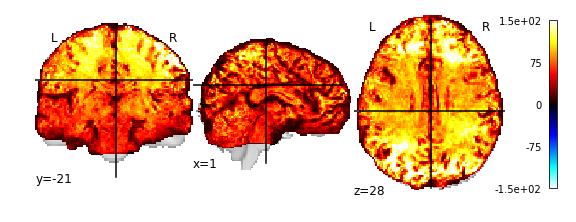

In [15]:
%matplotlib inline
plotting.plot_stat_map(index_img(data, 0), vmax=150)

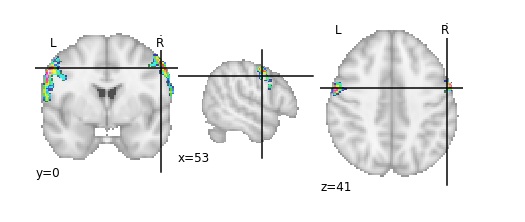

In [16]:
plotting.plot_roi(index_img(atlas.maps, 1))

In [12]:
ccs = find_xyz_cut_coords(index_img(atlas.maps, 4))

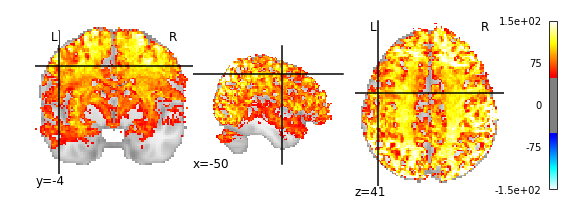

In [52]:
plotting.plot_stat_map(index_img(data, 0), cut_coords=ccs, vmax=150, threshold=50)

In [55]:
get_volume(data, 0).get_data().min()

0.0

In [38]:
# manually mask

In [56]:
mask_manual = index_img(atlas.maps, map_id).get_data() > 0.1

In [57]:
data.shape

(121, 144, 121, 11)

In [58]:
index_img(data, 0).get_data()[mask_manual].mean()

48.64166

In [53]:
map_id = 6

In [54]:
np.sum(index_img(data, 0).get_data() * index_img(atlas.maps, map_id).get_data())/index_img(atlas.maps, map_id).get_data().sum()

48.983303

In [45]:
sub = '01'
run = 1
root_dir = './data/deriv/fmriprep'
hdr = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_bold.nii.gz'.format(sub, sub, run))
hdr = nib.load(hdr)

data = hdr.get_data()
tsnr = data.mean(-1)/data.std(-1)

/home/stevenm/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [46]:
tsnr_img = nib.Nifti1Image(tsnr, hdr.affine)

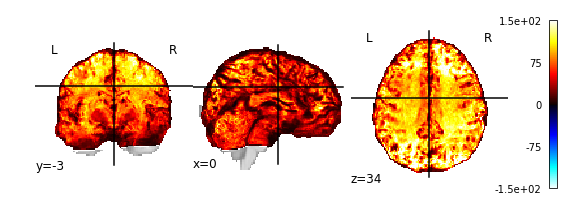

In [47]:
plotting.plot_stat_map(tsnr_img, vmax=150)

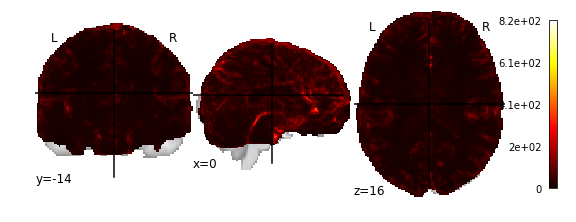

In [91]:
sub = '01'
run = 1
root_dir = './data/deriv/fmriprep'
hdr = os.path.join(root_dir, 'sub-{}/ses-se/func/sub-{}_ses-se_task-stop_run-{}_space-MNI152NLin2009cAsym_desc-preproc-hp_tsnr.nii.gz'.format(sub, sub, run))
plotting.plot_stat_map(index_img(hdr, 2))